<a href="https://colab.research.google.com/github/Josphat-Malombe/deep_learning/blob/main/animal_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od

url="https://www.kaggle.com/datasets/andrewmvd/animal-faces"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: josphatmalombe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
image_path=[]
labels=[]

for i in os.listdir("/content/animal-faces/afhq"):

  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):

    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)


data_df=pd.DataFrame({"image_path":image_path,"labels":labels})
print(data_df["labels"].unique())
data_df.head()


['dog' 'wild' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/flickr_do...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [ ]:
train=data_df.sample(frac=0.7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5)
test=test.drop(val.index)

print(train.shape,test.shape,val.shape)


(11291, 2) (2419, 2) (2420, 2)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(data_df["labels"  ])

transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [ ]:
class custom_dataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.Tensor(label_encoder.transform(dataframe['labels'])).type(torch.LongTensor).to(device)
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    image_path=self.dataframe.iloc[idx,0]
    label=self.labels[idx]

    image=Image.open(image_path).convert("RGB")
    if self.transform:
      image=self.transform(image).to(device)
    return image,label

In [ ]:
train_dataset=custom_dataset(train,transform)
test_dataset=custom_dataset(test,transform)
val_dataset=custom_dataset(val,transform)

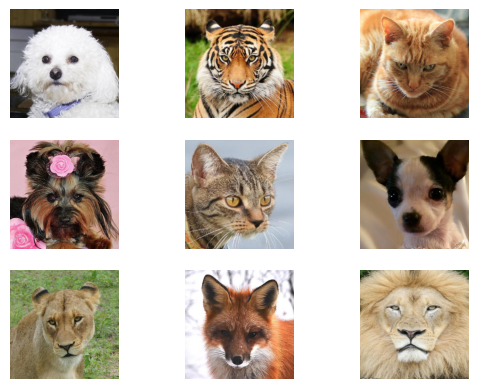

In [ ]:
f,axarr=plt.subplots(3,3)

for row in range(3):
  for col in range(3):
    image=Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis("off")
plt.show()


In [ ]:
train_dataloader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=32,shuffle=False)
val_dataloader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [ ]:
class modelclassification(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)

    self.pooling=nn.MaxPool2d(2,2)
    self.ReLU=nn.ReLU()

    self.flatten=nn.Flatten()
    self.linear=nn.Linear((128*16*16),128)

    self.output=nn.Linear(128,len(data_df["labels"].unique()))

  def forward(self,x):
    x=self.conv1(x)
    x=self.pooling(x)
    x=self.ReLU(x)

    x=self.conv2(x)
    x=self.pooling(x)
    x=self.ReLU(x)

    x=self.conv3(x)
    x=self.pooling(x)
    x=self.ReLU(x)

    x=self.flatten(x)
    x=self.linear(x)
    x=self.output(x)

    return x



In [ ]:
model=modelclassification().to(device)

In [ ]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs=100

total_train_loss=[]
total_val_loss=[]
total_train_acc=[]
total_val_acc=[]

for epoch in range(epochs):
  train_loss,val_loss,train_acc,val_acc=0,0,0,0
  for inputs,labels in train_dataloader:

    optimizer.zero_grad()

    output=model(inputs)
    loss=criterion(output,labels)
    train_loss+=loss.item()
    acc=(torch.argmax(output,dim=1)==labels).sum().item()
    train_acc+=acc

    loss.backward()
    optimizer.step()


  with torch.no_grad():
    model.eval()
    for inputs,labels in val_dataloader:
      output=model(inputs)
      loss=criterion(output,labels)
      val_loss+=loss.item()
      acc=(torch.argmax(output,dim=1)==labels).sum().item()
      val_acc+=acc
  total_train_loss.append(round(train_loss/1000, 4))
  total_val_loss.append(round(val_loss/1000,4))
  total_train_acc.append(round((train_acc/train_dataset.__len__())*100,2))
  total_val_acc.append(round((val_acc/val_dataset.__len__())*100,2))

  print(f'''Epoch: {epoch/10}
  | Train loss: {round(train_loss/1000, 4)} | Train Accuracy :{round((train_acc/train_dataset.__len__())*100,2)}%
  | Validation Loss: {round(val_loss/1000,4)} | Validation Accuracy: {round((val_acc/val_dataset.__len__())*100,2)}%''')




In [ ]:
with torch.no_grad():
  test_loss,test_acc=0,0
  for inputs,labels in test_dataloader:
    output=model(inputs)
    loss=criterion(output,labels)
    test_loss+=loss.item()
    acc=(torch.argmax(output,dim=1)==labels).sum().item()
    test_acc+=acc
  print(f" Accuracy: {round((test_acc/test_dataset.__len__())*100,2)}% Test Loss: {round(test_loss/1000,4)}")


 Accuracy: 95.99% Test Loss: 0.0136


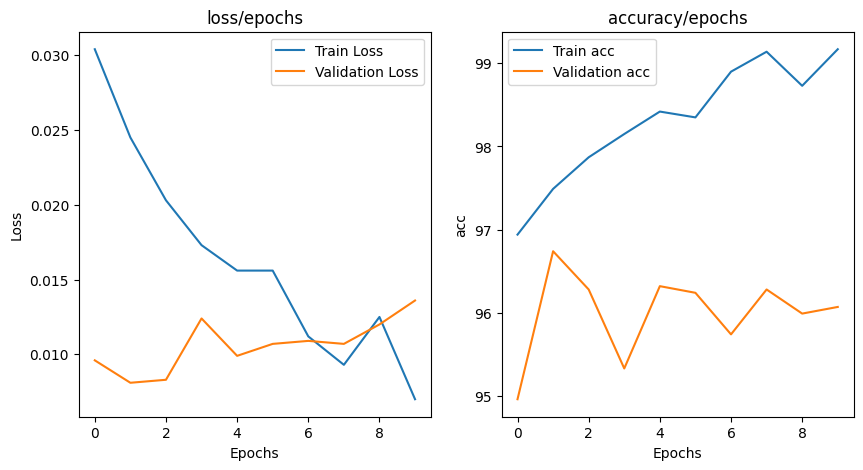

In [ ]:
fig,axs=plt.subplots(nrows=1,ncols=2,figsize=(10,5))

axs[0].plot(total_train_loss,label="Train Loss")
axs[0].plot(total_val_loss,label="Validation Loss")
axs[0].set_title("loss/epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()



axs[1].plot(total_train_acc,label="Train acc")
axs[1].plot(total_val_acc,label="Validation acc")
axs[1].set_title("accuracy/epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("acc")
axs[1].legend()


plt.show()

In [ ]:
from google.colab import files
def predict_image(uploaded_image):
  image=Image.open(uploaded_image).convert("RGB")
  image=transform(image).to(device)

  output=model(image.unsqueeze(0))

  output=torch.argmax(output, axis=1).item()

  return label_encoder.inverse_transform([output])


In [ ]:
uploaded_image="/content/download (1).jpeg"
predict_image(uploaded_image)

array(['wild'], dtype=object)